<a href="https://colab.research.google.com/github/CDAC-lab/AJCAI-Tutorial/blob/main/Deep%20Neural%20Networks%20for%20Price%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Networks for Standard Classification Problems - Price Prediction

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset challenges you to predict the final price of each home. The Kaggle challenge can be found [Here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


Load required libraries for modeling and data processing

In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Load the dataset

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authenticate and create the PyDrive client.

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

When prompted, click on the link to get authentication to allow Google to access your Drive. You should see a screen with “Google Cloud SDK wants to access your Google Account” at the top. After you allow permission, copy the given verification code and paste it in the box in Colab.

In [4]:
dataset_file_id = '1RBxydSbuwpMCVaJ2t6cHyNFYMGYvaD8P'

In [5]:
downloaded = drive.CreateFile({'id':dataset_file_id}) 
downloaded.GetContentFile('kaggle_housing_cleaned.csv')

Load the dataset file to a dataframe using Pandas library.

In [6]:
df = pd.read_csv('kaggle_housing_cleaned.csv')

In [7]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Id
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,1
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,2
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,3
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,4
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,5


Data description can be found from [this link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

We will use SalePrice variable as the predictor and store the predictor array using variable *Y*.

In [8]:
Y = df[['SalePrice']]

## Exploratory Analytics and pre-processing

First we will remove ID column and target column from the training dataset.

In [9]:
df.drop(['Id', 'SalePrice'], inplace=True, axis=1)

In [10]:
print('Dataset size: Rows - {}, Columns - {}'.format(df.shape[0], df.shape[1]))

Dataset size: Rows - 1460, Columns - 36


Note that for the experiment, we will only use the continuous variables.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

For the experiment, we will only use the continuous variables.

In [12]:
df_numerical = df.copy()

### Standardization

First we will have a look on the data distribution using a box plot.

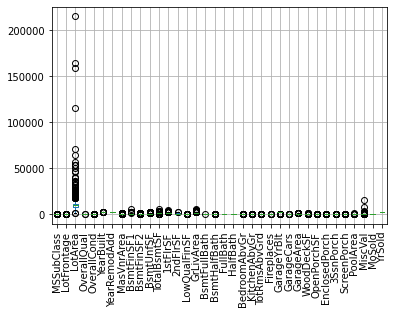

In [13]:
df_numerical.boxplot(rot=90)

We will normalize the continous variables using Min Max Normalization technique.  
Seperate normalizing objects are used for features and target variable(s).

In [14]:
from sklearn.preprocessing import MinMaxScaler
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

In [15]:
df_numerical = feature_scaler.fit_transform(df_numerical)

In [16]:
Y_scaled = target_scaler.fit_transform(Y)

## Modeling

In this workshop, we use Keras API to develop the deep neural network (DNN), on top of Tensorflow framework.  
Further details on the Keras API and how to customize models can be learnt from [the official Keras Guide](https://keras.io/getting-started/functional-api-guide/).  
  
The DNN model we will use is shown below.

![alt text](https://i.imgur.com/4cyoPiL.png)

Import Keras library with Tensorflow and sklearn for model development

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

Split the dataset (use 70/30 for train/test)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_numerical, Y_scaled, test_size=0.3, random_state=2)

First we will define a sequential model, which is the placeholder for our deep learning model.

In [19]:
NN_model = Sequential()

Next we will setup the first layer of our deep neural network (DNN). Here we initialize the input dimentions.  
Note that we will use 36 hidden nodes for each layer of our DNN. You may vary them in own experimental setup, in order to improve the accuracy.

In [20]:
NN_model.add(Dense(36, kernel_initializer='normal', input_dim = X_train.shape[1], activation='relu'))

After initiaing the first layer, we will define 2nd, 3rd and 4th layers similarly.  
However, we do not need to define the input dimensions in proceeding layers, as it will automatically detected from first layer.

In [21]:
NN_model.add(Dense(24, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(12, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(8, kernel_initializer='normal',activation='relu'))

Next we will define the output layer. As our output is a prediction of housing price, we will use a single linear activated output node.

In [22]:
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

Now we have completely defined the DNN model.  
Next step is to compile the DNN with [loss function](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23), [optimization](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3) function and metrics.  
In our experiment, we will use Mean Absolute Error loss as the loss function, and ADAM optimizer as the optimization function.


In [23]:
# Compile the DNN
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])

In [24]:
# Visualize the model summary
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36)                1332      
                                                                 
 dense_1 (Dense)             (None, 24)                888       
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 8)                 104       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,633
Trainable params: 2,633
Non-trainable params: 0
_________________________________________________________________


Now we will plot the model in a diagram.

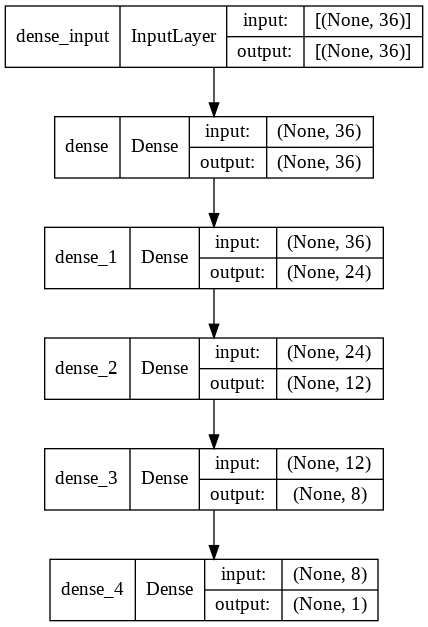

In [25]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(NN_model, to_file='model.png', show_shapes=True, show_layer_names=True)

Once the plotting is completed, you can go to Files tab and double click on the model.png file to visualize the model diagram.

## Model Training

Now, we will work on training the model.  
First we need to define 3 parameters,  


1.   Number of training epochs
2.   [The batch size](https://radiopaedia.org/articles/batch-size-machine-learning). i.e., how many training samples are used to iterate over once.
3.   Validation split (what percentage of data to keep as validation data)



In [26]:
epochs = 100             # Number of training epochs
batch_size = 32          # Number of data points to be used to train as a batch. Use to improve the model training time.
validation_split = 0.3   # Validation dataset size (percentage)

By calling model.fit(), you can initiate the training of the DNN.

In [27]:
# Train the model
history = NN_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = validation_split)

Epoch 1/100
23/23 [==============================] - 2s 10ms/step - loss: 0.1868 - mse: 0.0474 - val_loss: 0.1629 - val_mse: 0.0373
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1238 - mse: 0.0266 - val_loss: 0.0616 - val_mse: 0.0087
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0694 - mse: 0.0100 - val_loss: 0.0613 - val_mse: 0.0093
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0622 - mse: 0.0090 - val_loss: 0.0564 - val_mse: 0.0071
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0570 - mse: 0.0079 - val_loss: 0.0518 - val_mse: 0.0072
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.0509 - mse: 0.0067 - val_loss: 0.0451 - val_mse: 0.0058
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0423 - mse: 0.0050 - val_loss: 0.0365 - val_mse: 0.0037
Epoch 8/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0381 - 

Plot the learning curve, oppose to traning and validation errors.

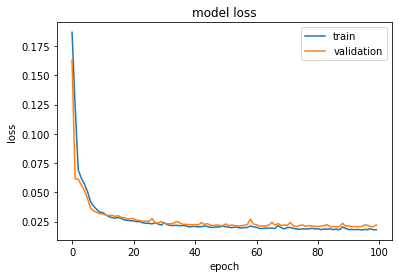

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

## Model Evaluation

Now we will test the trained DNN model with respect to the test dataset.

In [29]:
# Predicted output for test dataset
yhat_test = NN_model.predict(X_test)
yhat_train = NN_model.predict(X_train)

Recall how we standardized the data using scaler transform library in scikit-learn. Now, we will inverse transform the predictions back to its original range.

In [30]:
# inverse transform test dataset
inv_yhat = target_scaler.inverse_transform(yhat_test)
inv_y_test = target_scaler.inverse_transform(y_test)

In [31]:
# inverse transform train dataset
yhat_train = target_scaler.inverse_transform(yhat_train)
inv_y_train = target_scaler.inverse_transform(y_train)

Evaluate the root means squared error (RMSE)

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
error_train = np.sqrt(mean_squared_error(inv_y_train, yhat_train))
error_test = np.sqrt(mean_squared_error(inv_y_test, inv_yhat))
print('Train RMSE: ', error_train)
print('Test RMSE: ', error_test)

Train RMSE:  21959.330072429217
Test RMSE:  62385.295818139326


Relate the train and test error with bias/variance.  
*  What is the problem we have here?
*  What options we can take to improve the accuracy?

[Text(0, 0.5, 'Predicted Sale Price'),
 Text(0.5, 0, 'Actual Sale Price'),
 Text(0.5, 1.0, 'Train data')]

<Figure size 360x720 with 0 Axes>

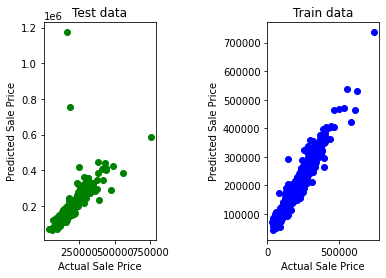

In [34]:
plt.figure(figsize=(5, 10))
fig, ax = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(hspace=3, wspace=1)
ax[0].scatter(inv_y_test, inv_yhat, c='g')
ax[0].set(title='Test data', xlabel='Actual Sale Price', ylabel='Predicted Sale Price')
ax[1].scatter(inv_y_train, yhat_train, c='b')
ax[1].set(title='Train data', xlabel='Actual Sale Price', ylabel='Predicted Sale Price')

## Hyperparameter Tuning

Adjusting/finding good values for hyperparameters is a slow process. You have to wait for the whole training process to complete, evaluate the results and adjust the value(s).  

In general, hyperparameter tuning can give you 5-15% accuracy boost on the test data.  

There are number of libraries to ease the process of hyperparameter tuning. Hyperas library [Link to library](https://github.com/maxpumperla/hyperas).  

Credits to Nils Schlüter for the guide on [running hyperas with Google Colab](https://towardsdatascience.com/keras-hyperparameter-tuning-in-google-colab-using-hyperas-624fa4bbf673).